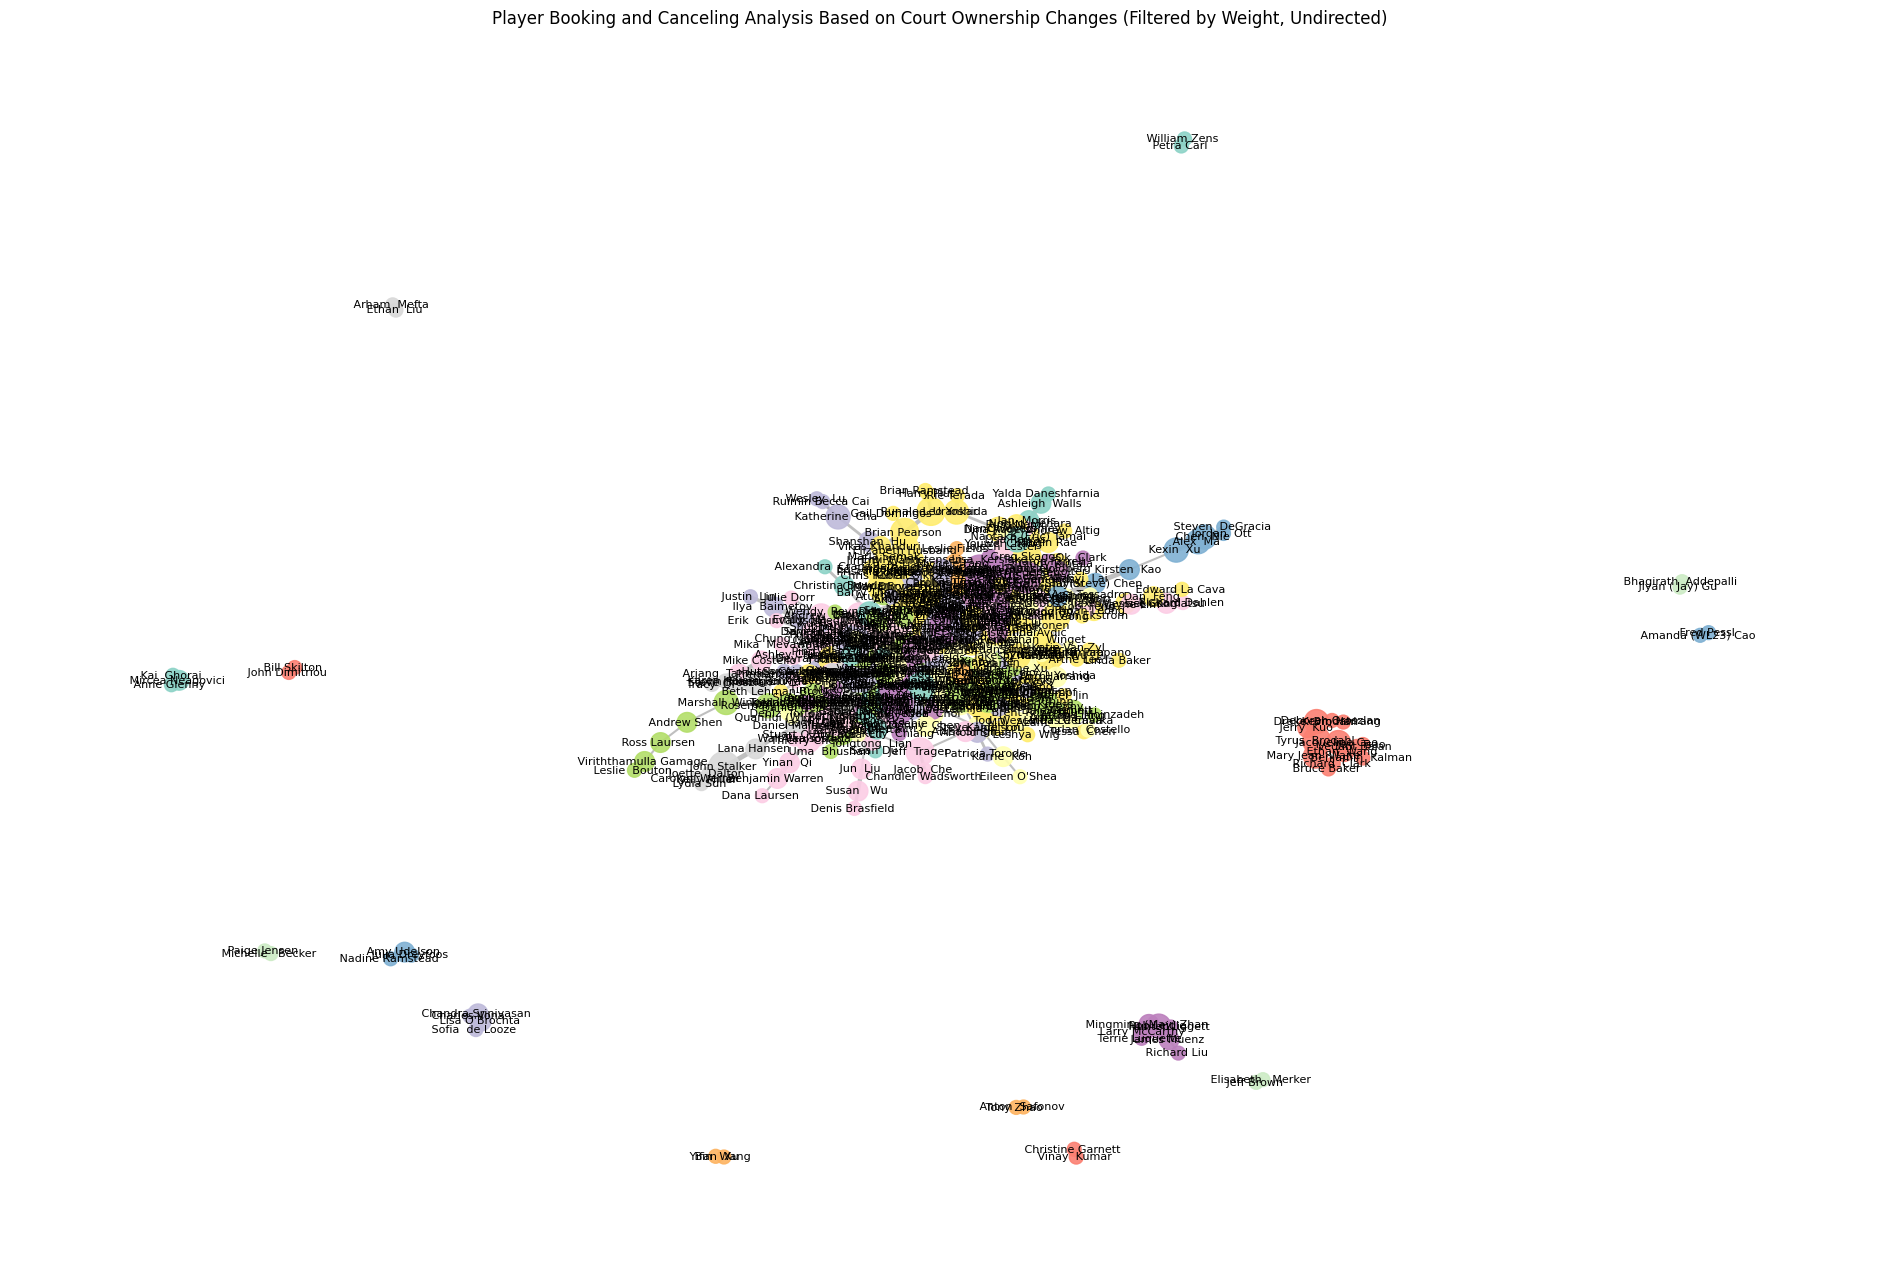

In [3]:
import os
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import community as community_louvain
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

# Retrieve connection details from environment variables
server = os.getenv("AZURE_SQL_SERVER")
database = os.getenv("AZURE_SQL_DATABASE")
username = os.getenv("AZURE_SQL_USER")
password = os.getenv("AZURE_SQL_PASSWORD")

# Define the connection string using SQLAlchemy format
conn_str = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

# Create an SQLAlchemy engine
engine = create_engine(conn_str)


# Step 1: Query data from the database and order by `runID`
query = """
    SELECT runId, courtNumber, dateId, timeId, p1
    FROM CourtBookingLog WHERE p1 IS NOT NULL AND p1 <> ''
    ORDER BY dateId, timeId, courtNumber, runId ASC
"""
df = pd.read_sql(query, engine)

# Step 1.5: Filter out rows where `p1` is None or NaN
df = df[df['p1'].notna()]

# Step 2: Identify changes in `p1` for the same `DateId`, `timeID`, `courtNumber`
# Initialize an empty undirected graph
G = nx.Graph()

# Group by `DateId`, `timeID`, and `courtNumber` to track changes in `p1`
for _, group in df.groupby(['dateId', 'timeId', 'courtNumber']):
    previous_player = None
    
    # Iterate over sorted runIDs to detect changes in `p1`
    for _, row in group.iterrows():
        current_player = row['p1']
        
        # Check that both previous_player and current_player are not None
        if previous_player and current_player and current_player != previous_player:
            # Create an undirected edge from previous player to current player
            if G.has_edge(previous_player, current_player):
                G[previous_player][current_player]['weight'] += 1
            else:
                G.add_edge(previous_player, current_player, weight=1)
        
        previous_player = current_player

# Step 3: Filter edges by weight threshold
weight_threshold = 3  # Adjust this value based on your preference
edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= weight_threshold]
G_filtered = G.edge_subgraph(edges_to_keep).copy()  # Create a subgraph with only high-weight edges

# Apply Louvain clustering to detect communities
partition = community_louvain.best_partition(G_filtered, weight='weight')

# Define layout and visualization properties
pos = nx.spring_layout(G_filtered, seed=42)
node_sizes = [G_filtered.degree(node) * 100 for node in G_filtered]
clusters = [partition[node] for node in G_filtered]

# Visualize the filtered graph
plt.figure(figsize=(24, 16))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=clusters, cmap='Set3', alpha=0.9)
nx.draw_networkx_edges(G_filtered, pos, width=[G_filtered[u][v]['weight'] * 0.5 for u, v in G_filtered.edges()], alpha=0.5, edge_color="grey")
nx.draw_networkx_labels(G_filtered, pos, font_size=8, font_color="black")
plt.title("Player Booking and Canceling Analysis Based on Court Ownership Changes (Filtered by Weight, Undirected)")
plt.axis("off")
plt.show()


In [6]:
# Calculate total connection weight for each player and store in a list
player_weights = []
for node in G_filtered.nodes():
    total_weight = sum(d['weight'] for _, _, d in G_filtered.edges(node, data=True))
    player_weights.append((node, total_weight))

# Sort players by descending weight
player_weights.sort(key=lambda x: x[1], reverse=True)

# Display the top 15 players and their weights
print("Top 15 players sorted by total connection weight (descending):")
for player, weight in player_weights[:15]:  # Slice to get only the top 15 players
    print(f"{player} (Total Weight: {weight})")


Top 15 players sorted by total connection weight (descending):
 Venkata  Mahankali   (Total Weight: 36)
 Ruth  Sun   (Total Weight: 35)
 Kristina Edmonson   (Total Weight: 35)
 Josh Pereira   (Total Weight: 35)
 Austin  He   (Total Weight: 35)
 Amy  Taylor   (Total Weight: 35)
 Joe Morrow   (Total Weight: 35)
 Ella Xu   (Total Weight: 34)
 Lily  Zhang   (Total Weight: 34)
 Wei Yang   (Total Weight: 33)
 June Pereira   (Total Weight: 33)
 Ryan Caldeiro   (Total Weight: 33)
 Kay Stalker   (Total Weight: 32)
 Rich  Choi   (Total Weight: 32)
 Cindy Duryee   (Total Weight: 32)


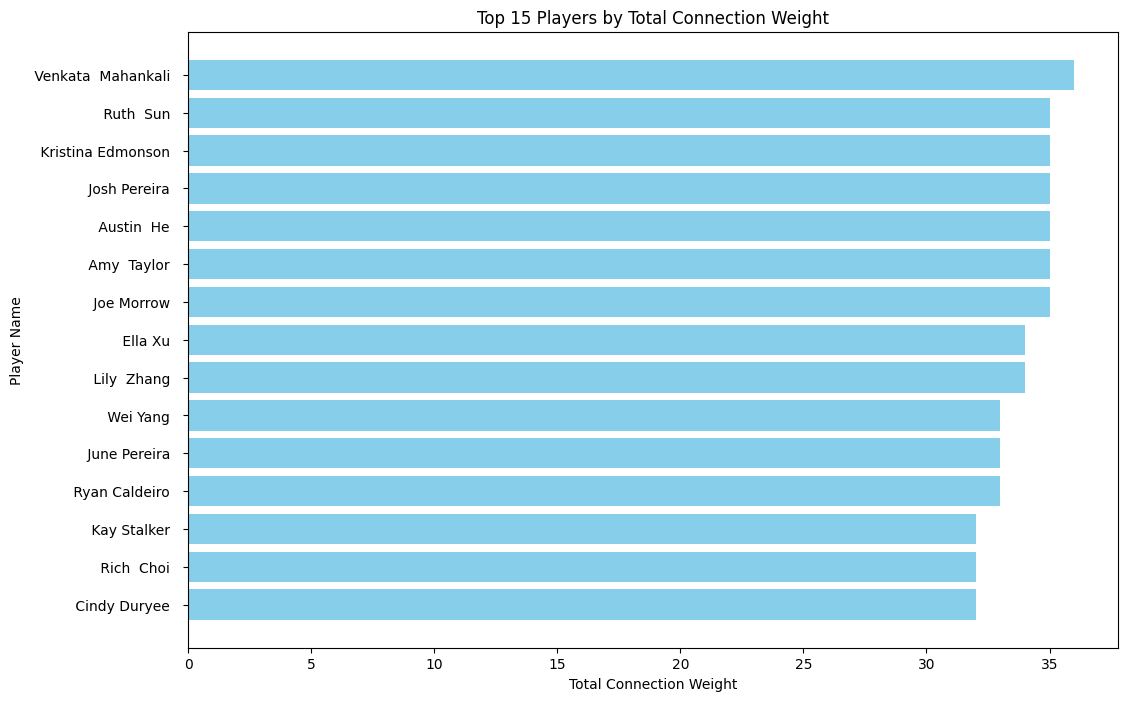

In [ ]:
import matplotlib.pyplot as plt

# Calculate total connection weight for each player and store in a list
player_weights = []
for node in G_filtered.nodes():
    total_weight = sum(d['weight'] for _, _, d in G_filtered.edges(node, data=True))
    player_weights.append((node, total_weight))

# Sort players by descending weight
player_weights.sort(key=lambda x: x[1], reverse=True)

# Select the top 15 players
top_15_players = player_weights[:15]
top_15_names = [player for player, weight in top_15_players]
top_15_weights = [weight for player, weight in top_15_players]

# Create a bar graph for the top 15 players
plt.figure(figsize=(12, 8))
plt.barh(top_15_names, top_15_weights, color="skyblue")
plt.xlabel("Total Connection Weight")
plt.ylabel("Player Name")
plt.title("Top 15 Players by Total Connection Weight")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest weight at the top
plt.show()


In [12]:
# Convert dateId to datetime format and extract day of the week
df['dateId'] = pd.to_datetime(df['dateId'], format='%d/%m/%Y')
df['dayOfWeek'] = df['dateId'].dt.day_name()

# Step 1: Get the top players by weight (e.g., top 15)
top_weighted_players = {player for player, weight in player_weights[:15]}

# Step 2: Find records where p1 changes within groups and includes a top-weighted player
print("Distinct records grouped by dateId, timeId, and courtNumber where p1 changed and includes a top-weighted player:")

# Group by dateId, timeId, courtNumber and check for changes in p1
for (date_id, time_id, court_num), group in df.groupby(['dateId', 'timeId', 'courtNumber']):
    # Sort group by runId for sequential changes and get unique p1 values in order
    group_sorted = group.sort_values(by='runId')
    unique_p1 = group_sorted['p1'].dropna().unique()

    # Check if p1 changed (more than one unique p1) and if any p1 in the group is a top-weighted player
    top_player_in_group = [p1 for p1 in unique_p1 if p1 in top_weighted_players]
    if len(unique_p1) > 1 and top_player_in_group:
        top_player_name = top_player_in_group[0]  # Get the first top-weighted player found in the group
        day_of_week = group_sorted['dayOfWeek'].iloc[0]  # Get the day of the week for the group
        
        print(f"\nDate: {date_id.date()}, Time: {time_id}, Court Number: {court_num}, Day of Week: {day_of_week}")
        print(f"Top Weighted Player Involved: {top_player_name}")
        
        # Print distinct records for this combination without runId
        distinct_records = group_sorted[['dateId', 'dayOfWeek', 'timeId', 'courtNumber', 'p1']].drop_duplicates()
        print(distinct_records)


Distinct records grouped by dateId, timeId, and courtNumber where p1 changed and includes a top-weighted player:

Date: 2024-10-22, Time:  7:00 pm, Court Number: 8, Day of Week: Tuesday
Top Weighted Player Involved:  Lily  Zhang  
          dateId dayOfWeek    timeId  courtNumber              p1
75641 2024-10-22   Tuesday   7:00 pm            8   Lily  Zhang  
75642 2024-10-22   Tuesday   7:00 pm            8   Phillip  Lu  

Date: 2024-10-22, Time:  7:30 pm, Court Number: 12, Day of Week: Tuesday
Top Weighted Player Involved:  Kristina Edmonson  
          dateId dayOfWeek    timeId  courtNumber                     p1
75681 2024-10-22   Tuesday   7:30 pm           12    Kristina Edmonson  
75682 2024-10-22   Tuesday   7:30 pm           12   Stephen  Stukovsky  

Date: 2024-10-22, Time: 10:00 am, Court Number: 4, Day of Week: Tuesday
Top Weighted Player Involved:  Cindy Duryee  
          dateId dayOfWeek    timeId  courtNumber               p1
75888 2024-10-22   Tuesday  10:00 am     